In [269]:
import openrouteservice
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import pandas as pd
import numpy as np

Population within 1-hour drive time: 8094793.0


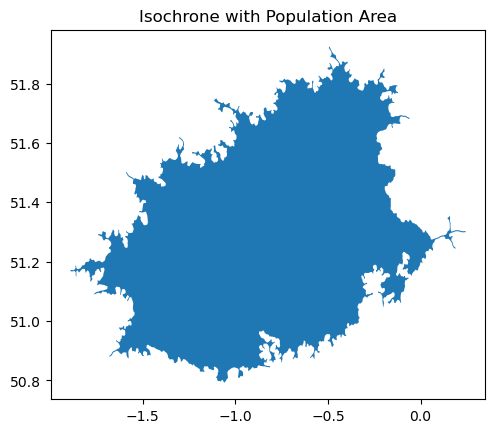

In [7]:
# Your ORS API key
api_key = '5b3ce3597851110001cf6248b79f1a724fa34b319b3fc464e0e491b8'

# Initialize the client
client = openrouteservice.Client(key=api_key)

# Define the coordinates of the point (e.g., Farnborough, UK)
coords = (-0.7521625439493003, 51.28508816635469, )  # Replace with your desired coordinates

# Generate the isochrone with a 1-hour drive time (3600 seconds)
isochrone = client.isochrones(
    locations=[coords],
    range_type='time',  # Alternatively, use 'distance' for distance-based isochrones
    range=[3600],  # Time in seconds (1 hour = 3600 seconds)
    profile='driving-car',
    attributes = ['total_pop']
)

# Get the isochrone geometry (polygon) and population data
isochrone_geom = isochrone['features'][0]['geometry']
population = isochrone['features'][0]['properties']['total_pop']

# Print the population in the isochrone area
print(f"Population within 1-hour drive time: {population}")

# Visualize the isochrone and population area
isochrone_polygon = Polygon(isochrone_geom['coordinates'][0])

# Create a GeoDataFrame for the isochrone polygon
gdf_isochrone = gpd.GeoDataFrame({'geometry': [isochrone_polygon]}, crs="EPSG:4326")

# Plot the isochrone polygon
gdf_isochrone.plot()
plt.title('Isochrone with Population Area')
plt.show()


In [133]:
def getPolyPop(lat, long, drive_secs):
    
    coords = (long,lat)

    try:
        client = openrouteservice.Client(key=api_key)
        isochrone = client.isochrones(
            locations=[coords],
            range_type='time',  # Alternatively, use 'distance' for distance-based isochrones
            range=[drive_secs],  # Time in seconds (1 hour = 3600 seconds)
            profile='driving-car',
            attributes = ['total_pop']
        )

        # Get the isochrone geometry (polygon) and population data
        coordinates = [list(reversed(coord)) for coord in isochrone['features'][0]['geometry']['coordinates'][0]]
        population = isochrone['features'][0]['properties']['total_pop']

        return [population, coordinates]

    except:
        return [None, None]

In [ ]:
df_postcodes['population_1hr_drive'] = None
df_postcodes['coordinates'] = None

In [307]:
gpop, gcoords = getPolyPop(df_postcodes['latitude'][37], df_postcodes['longitude'][37], 3600)

In [309]:
df_postcodes[df_postcodes['postcode'] == 'G']

postcode   latitude  longitude  population_1hr_drive coordinates geometry
37        G  55.993213  -4.438944                   NaN        None     None

In [135]:
# Loop through each row and apply the function
for idx, row in df_postcodes[37:].iterrows():
    pop, coords = getPolyPop(row['latitude'], row['longitude'], 3600)  # 3600 is the time in seconds (e.g., 1 hour)
    df_postcodes.at[idx, 'population'] = pop
    df_postcodes.at[idx, 'coordinates'] = coords

In [ ]:
df_postcodes.drop(columns='population_1hr_drive', inplace=True)
df_postcodes.rename(columns={'population' : 'population_1hr_drive'}, inplace=True)
df_postcodes = df_postcodes[['postcode', 'latitude', 'longitude','population_1hr_drive', 'coordinates']].copy()

In [153]:
df_postcodes = df_postcodes.copy()

In [154]:
df_postcodes["geometry"] = df_postcodes["coordinates"].apply(lambda x: Polygon(x) if x else None)

In [159]:
gdf_postcodes = gpd.GeoDataFrame(df_postcodes, geometry="geometry", crs="EPSG:4326")
gdf_postcodes.drop(columns='coordinates', inplace=True)

In [203]:
from shapely.ops import transform
from functools import partial

def safe_swap_coordinates(geom):
    if geom is None:
        return None
    
    def swap_xy(x, y):
        return (y, x)
    
    return transform(partial(swap_xy), geom)

# Apply the transformation only to valid geometries
gdf_postcodes.geometry = gdf_postcodes.geometry.apply(safe_swap_coordinates)

In [208]:
gdf_postcodes.to_file("ukDriveTimesPops.geojson", driver="GeoJSON")

In [163]:
df_postcodes[['postcode', 'latitude',
'longitude', 'population_1hr_drive']].to_csv('UKpostcodeDriveTimePop.csv', index=False)

In [ ]:
m = folium.Map(location=[51.503497255814956, -0.10784770401512589], tiles='cartodbpositron', zoom_start=13)

for iso in isochrone['features']:
    folium.Polygon(locations=[list(reversed(coord)) for coord in iso['geometry']['coordinates'][0]],
                  fill='00ff00',
                  popup=folium.Popup("Population: {} people".format(iso['properties']['total_pop'])),
                  opacity=0.5).add_to(m)
    
m

In [59]:
df_postcodes = pd.read_csv('postcode_area_centroids.csv')

In [209]:
gdf_postcodes2 = gpd.read_file('ukDriveTimesPops.geojson')

In [ ]:
gdf_postcodes2['pop_mill'] = round(gdf_postcodes2['population_1hr_drive'] / 1000000, 2).astype(str) + "m"
gdf_postcodes2.dropna(subset='geometry', inplace=True)

In [ ]:
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=5)

for index, row in gdf_postcodes2.iterrows():
    polygon = row["geometry"]
    postcode = row["postcode"]  # Adjust column name as needed
    population = row["pop_mill"]  # Adjust column name as needed

    # Get the centroid to center the map
    centroid = polygon.centroid

    # Add the polygon with tooltip
    folium.GeoJson(
        polygon,
        tooltip=f"Postcode: {postcode}<br>Population: {population}"
    ).add_to(m)

    folium.Marker(
        location = [row['latitude'], row['longitude']]
    ).add_to(m)

# Display the map
m

## get postcode area coords

In [232]:
string = 'AB AL B BA BB BD BF BH BL BN BR BS BT BX CA CB CF CH CM CO CR CT CV CW DA DD DE DG DH DL DN DT DY E EC EH EN EX FK FY G GL GU GY HA HD HG HP HR HS HU HX IG IM IP IV JE KA KT KW KY L LA LD LE LL LN LS LU M ME MK ML N NE NG NN NP NR NW OL OX PA PE PH PL PO PR RG RH RM S SA SE SG SK SL SM SN SO SP SR SS ST SW SY TA TD TF TN TQ TR TS TW UB W WA WC WD WF WN WR WS WV YO ZE'
list_str = string.split(' ')

In [ ]:
rows = []
for postcode in list_str:
    try:
        # Try reading the geojson file for each postcode
        gdf = gpd.read_file(f"https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/refs/heads/master/geojson/{postcode}.geojson")
        
        centroid = gdf.unary_union.centroid
        rows.append([postcode, centroid.y, centroid.x])
    
    except Exception as e:
        # If an error occurs, print a message and skip this postcode
        print(f"Failed to read file for postcode {postcode}: {e}")
        continue

df = pd.DataFrame(rows, columns=['postcode', 'latitude', 'longitude'])

In [241]:
rows = []
for postcode in list_str:
    try:
        # Try reading the geojson file for each postcode
        gdf = gpd.read_file(f"https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/refs/heads/master/geojson/{postcode}.geojson")
        
        polygon = gdf.unary_union
        rows.append([postcode, polygon])
    
    except Exception as e:
        # If an error occurs, print a message and skip this postcode
        print(f"Failed to read file for postcode {postcode}: {e}")
        continue

df_uk_poly = pd.DataFrame(rows, columns=['postcode', 'geometry'])
gdf_uk_poly = gpd.GeoDataFrame(df_uk_poly, geometry='geometry')

Failed to read file for postcode BF: HTTP Error 404: Not Found
Failed to read file for postcode BT: HTTP Error 404: Not Found
Failed to read file for postcode BX: HTTP Error 404: Not Found
Failed to read file for postcode GY: HTTP Error 404: Not Found
Failed to read file for postcode IM: HTTP Error 404: Not Found
Failed to read file for postcode JE: HTTP Error 404: Not Found


In [245]:
gdf_uk_poly.to_file('uk_postcode_area_polygons.geojson', driver="GeoJSON")

In [47]:
df.to_csv('postcode_area_centroids.csv', index=False)

In [247]:
gdf_postcodes2.columns

Index(['postcode', 'latitude', 'longitude', 'population_1hr_drive', 'geometry',
       'pop_mill'],
      dtype='object')

In [256]:
gdf_merged = pd.merge(gdf_uk_poly, gdf_postcodes2[['postcode', 'latitude', 'longitude',
 'population_1hr_drive','pop_mill']], on='postcode', how='left')

In [258]:
gdf_merged = gdf_merged.set_crs(epsg=4326)

In [264]:
gdf_merged['geometry'].isna().sum()

0

In [ ]:
m = folium.Map(location=[54.7, -2.92], zoom_start=5)

for index, row in df_merged.iterrows():
    polygon = row["geometry"]
    postcode = row["postcode"]  # Adjust column name as needed
    population = row['population_1hr_drive']
    pop_label = row['pop_mill']

    # Add the polygon with tooltip
    folium.GeoJson(
        polygon,
        tooltip=f"Postcode: {postcode}<br> Pop within 1 hour: {pop_label}"
    ).add_to(m)
# Display the map
m

In [348]:
m = folium.Map(location=[53.7, -2.92], zoom_start=5, tiles="Cartodb Positron")

# Create Choropleth Layer
folium.Choropleth(
    geo_data=gdf_merged,  # GeoDataFrame with geometries
    name="Population Density",
    data=gdf_merged,  # Data source for coloring
    columns=["postcode", "population_1hr_drive"],  # Key column & value column
    key_on="feature.properties.postcode",  # Match geojson with df column
    fill_color="YlGnBu",  # Color scheme (Yellow-Orange-Red)
    fill_opacity=0.6,
    line_weight=1,
    legend_name="Population within 1-hour Drive",
).add_to(m)

# Add GeoJSON layer with tooltips
for _, row in gdf_merged.iterrows():
    folium.GeoJson(
        row["geometry"],
        tooltip=f"Postcode: {row['postcode']}<br> Pop within 1 hour: {row['pop_mill']}",
        style_function=lambda feature: {"fillOpacity": 0, "weight": 0.1},  # Keep polygons visible but not colored
    ).add_to(m)

    # Add center point markers
    # if pd.notna(row["latitude"]) and pd.notna(row["longitude"]):
    #     folium.Circle(
    #         location=[row["latitude"], row["longitude"]],
    #         radius=3000,
    #         color = "orange",
    #         weight=1,
    #         fill_opacity = 0.2,
    #         tooltip=f"Postcode: {row['postcode']}<br> Pop within 1 hour: {row['pop_mill']}",
    #     ).add_to(m)

#Display the map
m